# Training and Validation Script

## Import Library

In [1]:
import os
import re
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import gdown
import zipfile

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Import Dataset

In [2]:
# download zip file dataset from https://drive.google.com/file/d/1XeG9uoCu6Cokx2hlYVbHyy2OUONmsK-u/view?usp=share_link

url = "https://drive.google.com/file/d/1XeG9uoCu6Cokx2hlYVbHyy2OUONmsK-u/view?usp=share_link"
output = "dataset.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1XeG9uoCu6Cokx2hlYVbHyy2OUONmsK-u
To: /content/dataset.zip
100%|██████████| 8.64M/8.64M [00:00<00:00, 38.4MB/s]


'dataset.zip'

In [3]:
filenames = os.listdir()

for file in filenames:
  dataset = re.search(r'^dataset.*\.zip$', file)

  if dataset:
    zip_path = f'./{file}'
    zip_ref = zipfile.ZipFile(zip_path, 'r')
    zip_ref.extractall(path='./')
    zip_ref.close()

## ETL (Extract Transform Load)

In [76]:
# Create dataset builder

# Extract (Specifying path)
base_dir = './dataset/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Extract (Generating dataset from directory)
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
VAL_SPLIT = 0.2

def build_dataset(train_val, dir, subset=None):
  if train_val:
    return tf.keras.preprocessing.image_dataset_from_directory(
        dir,
        validation_split=VAL_SPLIT,
        subset=subset,
        label_mode='binary',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        seed=123)
  else:
    return tf.keras.preprocessing.image_dataset_from_directory(
        dir,
        labels='inferred',
        label_mode='binary',
        class_names=['caries', 'no-caries'],
        batch_size=BATCH_SIZE,)


# Execute dataset building
train_ds = build_dataset(True, train_dir, "training")
val_ds = build_dataset(True, train_dir, "validation")
test_ds = build_dataset(False, test_dir)

class_names = train_ds.class_names
print(class_names)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.
Found 56 files belonging to 2 classes.
['caries', 'no-caries']


In [73]:
# # Check batches' shape
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

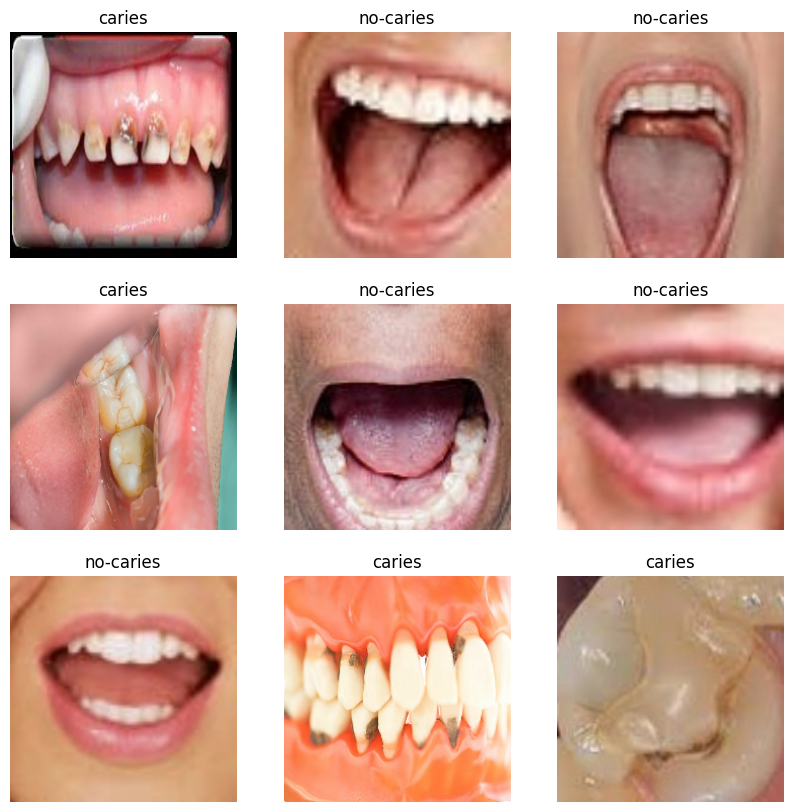

In [54]:
# Visualize dataset image

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    labels = labels.numpy().astype("uint8")
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

### Preprocessing Images using keras preprocessing layers

In [77]:
# Transform (Preprocessing data)

# optimize data I/O
AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = 224

image = next(iter(train_ds))

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  # layers.RandomTranslation(0, 0.2),
  # layers.RandomTranslation(0.2, 0),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomBrightness(0.1)
])

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [78]:
# Load (Apply preprocessing and load data)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Building Model using Transfer Learning

In [79]:
# transfer learning not final (maybe can use less layer?)
model_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = model_selection
IMAGE_SIZE = (pixels, pixels)

MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
feature_extractor = hub.KerasLayer(MODULE_HANDLE, 
                                   input_shape=IMAGE_SIZE + (3,),
                                   trainable=False)

print(f"Selected model: {MODULE_HANDLE}")

Selected model: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


In [58]:
# # Check feature vector dimension

# image_batch, label_batch = next(iter(train_ds))
# feature_batch = pre_trained_model(image_batch)
# print(feature_batch.shape)

In [120]:
# define model architecture

output = 1 #@param {type:"integer"}
activation = "sigmoid" #@param ["sigmoid", "softmax", "linear"]


model = tf.keras.Sequential([
    layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor,
    # Our custom output layer
    layers.Dense(units=output, activation=activation, name="output")
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 output (Dense)              (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [121]:
from_logits = False #@param {type:"boolean"}

model.compile(
  optimizer = optimizers.Adam(learning_rate=0.001), 
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=from_logits),
  metrics = ['accuracy']
)

## Model Training with freezed layers

In [122]:
# Define callback functions

import datetime

def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
  ]

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir,
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [123]:
NUM_EPOCHS = 500

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = NUM_EPOCHS,
  verbose = 2,
  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                         experiment_name="Training Model at " + datetime.datetime.now().strftime("%H%M")), 
             get_callbacks()])

Saving TensorBoard log files to: tensorflow_hub/Training Model at 0526/20230606-052646
Epoch 1/500
13/13 - 8s - loss: 0.7097 - accuracy: 0.5125 - val_loss: 0.6564 - val_accuracy: 0.6300 - 8s/epoch - 592ms/step
Epoch 2/500
13/13 - 3s - loss: 0.6708 - accuracy: 0.5800 - val_loss: 0.5972 - val_accuracy: 0.6600 - 3s/epoch - 259ms/step
Epoch 3/500
13/13 - 3s - loss: 0.6384 - accuracy: 0.6175 - val_loss: 0.4929 - val_accuracy: 0.8300 - 3s/epoch - 246ms/step
Epoch 4/500
13/13 - 4s - loss: 0.6237 - accuracy: 0.6250 - val_loss: 0.4675 - val_accuracy: 0.8300 - 4s/epoch - 311ms/step
Epoch 5/500
13/13 - 3s - loss: 0.6222 - accuracy: 0.6150 - val_loss: 0.4136 - val_accuracy: 0.8700 - 3s/epoch - 246ms/step
Epoch 6/500
13/13 - 4s - loss: 0.5954 - accuracy: 0.6625 - val_loss: 0.3948 - val_accuracy: 0.8400 - 4s/epoch - 317ms/step
Epoch 7/500
13/13 - 3s - loss: 0.5940 - accuracy: 0.6575 - val_loss: 0.3824 - val_accuracy: 0.8600 - 3s/epoch - 259ms/step
Epoch 8/500
13/13 - 3s - loss: 0.5784 - accuracy: 0.

## Fine Tuning Model (Please RUN after training with freezed layers)
Prone to overfit

In [ ]:
feature_extractor.trainable = True

In [ ]:
model.compile(
  optimizer = optimizers.Adam(), 
  loss = 'binary_crossentropy', 
  metrics = ['accuracy']
)

In [ ]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 50,
  verbose = 2,
  callbacks=get_callbacks())

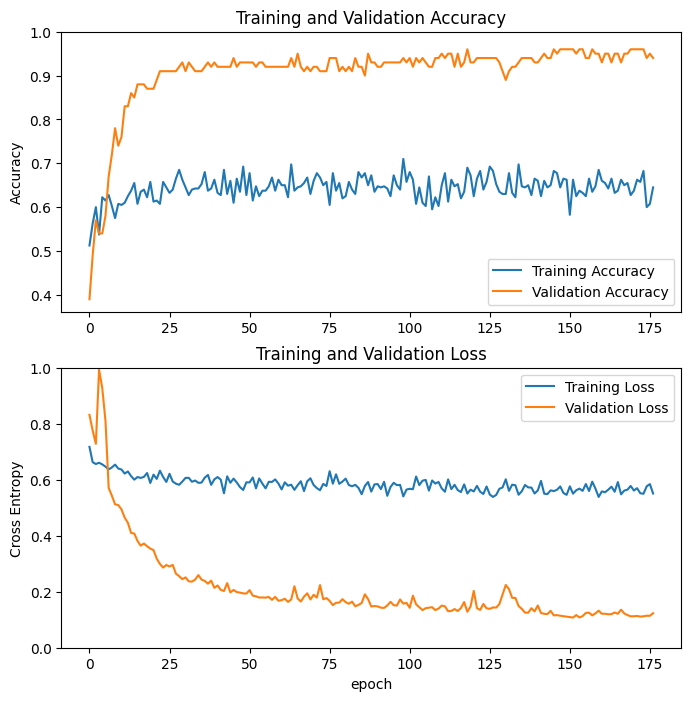

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## CNN WITHOUT Transfer Learning

In [ ]:
model = tf.keras.models.Sequential ([
    tf.keras.layers.Conv2D(32, (3, 3),activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 26, 26, 128)    

In [ ]:
model.compile(
  optimizer = optimizers.Adam(learning_rate=0.0001), 
  loss = 'binary_crossentropy', 
  metrics = ['accuracy']
)

In [ ]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 20,
  verbose = 2,
)

Epoch 1/20
13/13 - 9s - loss: 3.1773 - accuracy: 0.4725 - val_loss: 0.6944 - val_accuracy: 0.4700 - 9s/epoch - 675ms/step
Epoch 2/20
13/13 - 6s - loss: 0.7041 - accuracy: 0.4875 - val_loss: 0.6932 - val_accuracy: 0.5200 - 6s/epoch - 439ms/step
Epoch 3/20
13/13 - 7s - loss: 0.7207 - accuracy: 0.4975 - val_loss: 0.6924 - val_accuracy: 0.5300 - 7s/epoch - 521ms/step
Epoch 4/20
13/13 - 6s - loss: 0.7092 - accuracy: 0.4800 - val_loss: 0.6926 - val_accuracy: 0.6000 - 6s/epoch - 439ms/step
Epoch 5/20
13/13 - 7s - loss: 0.6891 - accuracy: 0.5300 - val_loss: 0.6919 - val_accuracy: 0.5300 - 7s/epoch - 510ms/step
Epoch 6/20
13/13 - 7s - loss: 0.7151 - accuracy: 0.5075 - val_loss: 0.6929 - val_accuracy: 0.4800 - 7s/epoch - 510ms/step
Epoch 7/20
13/13 - 6s - loss: 0.7034 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5300 - 6s/epoch - 444ms/step
Epoch 8/20
13/13 - 7s - loss: 0.7040 - accuracy: 0.4975 - val_loss: 0.6923 - val_accuracy: 0.5800 - 7s/epoch - 515ms/step
Epoch 9/20
13/13 - 6s - 

## Model Evaluation

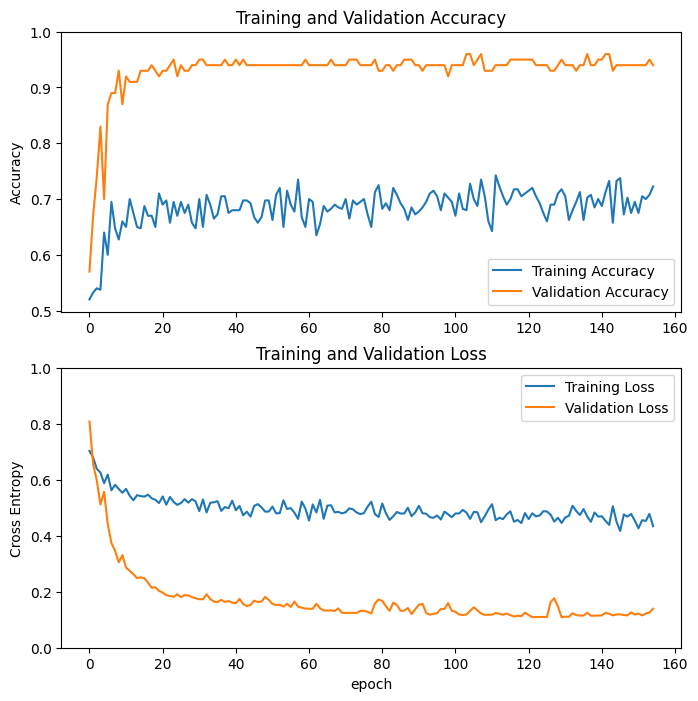

In [92]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [108]:
sample = test_ds.take(1)

evaluation = model.evaluate(sample, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 370ms/step - loss: 0.2756 - accuracy: 0.9375

loss: 0.2756
accuracy: 0.9375


## TensorBoard compare

In [95]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Confidentz Model Log" \
  --description "Comparing Confidentz models with limited amount of training images" \
  --one_shot

2023-06-06 05:11:10.665129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/723cA0rAQYGkbVu1nrx7kQ/

[2023-06-06T05:11:12] Started scanning logdir.
[2023-06-06T05:11:13] Total uploaded: 3558 scalars, 0 tensors, 0 binary objects
[2023-06-06T05:11:13] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/723cA0rAQYGkbVu1nrx7kQ/


In [ ]:
# Check out experiments (uncomment to see)
!tensorboard dev list 

2023-06-04 08:10:20.055273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/7dVsm7WjREq3IEQqclmIQg/
	Name                 Confidentz Model Log
	Description          Comparing Confidentz models with limited amount of training images
	Id                   7dVsm7WjREq3IEQqclmIQg
	Created              2023-06-04 07:51:56 (18 minutes ago)
	Updated              2023-06-04 07:51:56 (18 minutes ago)
	Runs                 2
	Tags                 4
	Scalars              570
	Tensor bytes         0
	Binary object bytes  0
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id zaoOrUv9SX6bW3JJV5bLNw

2023-06-04 05:05:47.942860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment zaoOrUv9SX6bW3JJV5bLNw.


## Predict Stuff

In [131]:
# change filename to file you want to predict
filename = 'no-caries.jpg'
img = load_img(filename, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array /= 255
img_array = np.expand_dims(img_array, axis=0)
images = np.vstack([img_array])
# print(img_array.shape)

prediction = model.predict(img_array, batch_size=10)
# print(prediction[0])

# # stack dimension vertically
# images = np.vstack([x])
# classes = model.predict(images, batch_size=10)
# conf_level = round(float(classes[0][0]),2)
# print("Caries detected") if conf_level > 0.75 else print("Caries undetected")
# print(conf_level)
# print(f"raw: {classes[0][0]}")

# img=load_img(path, target_size=(150, 150))

# x=img_to_array(img)
# x /= 255
# x=np.expand_dims(x, axis=0)
# images = np.vstack([x])

# classes = model.predict(images, batch_size=10)

# print(classes[0])

# if classes[0]>0.5:
#   print(fn + " is a dog")
# else:
#   print(fn + " is a cat")

score = prediction[0]
# score = tf.nn.softmax(prediction[0])
print(
    "Caries detected with a {:.2f} percent confidence."
    .format(100 * np.max(score))
)

(1, 224, 224, 3)
1/1 [==============================] - 0s 23ms/step
[1.6028384e-06]
Caries detected with a 0.00 percent confidence.


In [ ]:
# Save model to HDF5 format or .h5 file format

# Save the entire model to a HDF5 file.
model.save('confidentz_model.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
reloaded_model = tf.keras.models.load_model(
       ("confidentz_model.h5"),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

# Show the model architecture
reloaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 outputs (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Predict with reloaded model

# change filename to file you want to predict
filename = 'caries.jpg'
img = load_img(filename, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# stack dimension vertically
images = np.vstack([x])
classes = reloaded_model.predict(images, batch_size=10)
print(classes)

1/1 [==============================] - 0s 41ms/step
[[0.02425903]]


## TODO
* Build Flask app
* User image input???????
* ~~Create better evaluation and prediction~~
* ~~Create save model function to .h5 format~~
* How to deploy the model?